# Concept Drift Detection in Image Datasets

In many real-world applications relationship between input and output features is dynamic. The changing relationships within data over time is referred to as [Concept Drift](https://en.wikipedia.org/wiki/Concept_drift).

Often, temporal changes in data have unforeseen properties, resulting in unexpected degradation of model performance. In this notebook we will highlight how Ivis can be used to detect and measure Concept Drift in a collection of images. 

In [ ]:
!python3 -m pip install ivis

In [1]:
# Ivis uses several stochastic processes.
# To make sure that results are consistent from one run to another,
# we fix the random seed

import os
import cv2
os.environ["PYTHONHASHSEED"]="1234"

import random
import numpy as np

import tensorflow as tf

np.random.seed(1234)
random.seed(1234)
tf.random.set_seed(1234)

In [2]:
import matplotlib.pyplot as plt

from ivis import Ivis

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [4]:
def motion_blur(image, size=5):

    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size
    
    output = cv2.filter2D(image, -1, kernel_motion_blur)
    return output

## 1. Load Data

This example will use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The dataset consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. To artificially introduce Concept Drift, we will add motion blur to images in the testing set.

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

Let's add motion blur with increasing degree of severity:

In [6]:
X_test_blur_2 = np.array([motion_blur(x, size=2) for x in X_test])
X_test_blur_5 = np.array([motion_blur(x, size=5) for x in X_test])
X_test_blur_15 = np.array([motion_blur(x, size=15) for x in X_test])

Text(0.5, 1.0, 'Motion Blur (size=15)')

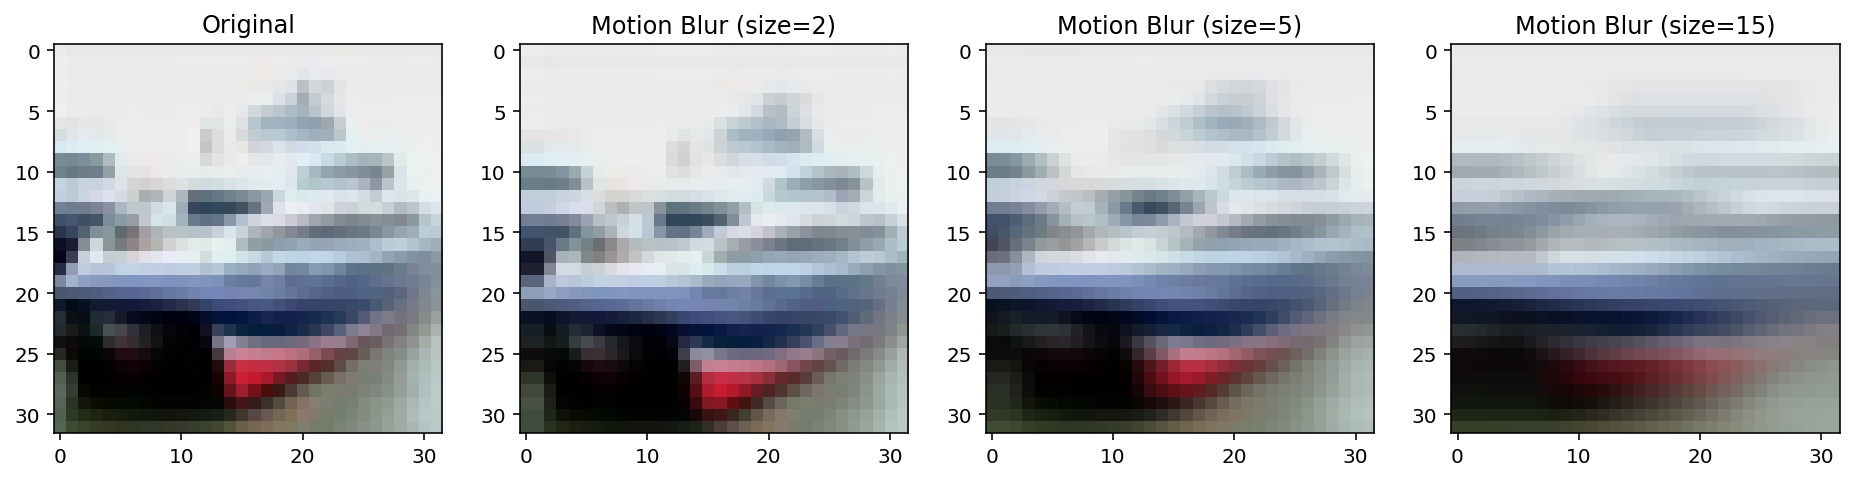

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(X_test[1])
axs[0].set_title('Original')
axs[1].imshow(X_test_blur_2[1])
axs[1].set_title('Motion Blur (size=2)')
axs[2].imshow(X_test_blur_5[1])
axs[2].set_title('Motion Blur (size=5)')
axs[3].imshow(X_test_blur_15[1])
axs[3].set_title('Motion Blur (size=15)')

## 2. Demonstrating Concept Trift

Concept Drift is demonstrated by training a very simple Convolutional Neural Network on running inference on original testing set, as well as pertured images. If the model is suscpetible to Concept Drift, we expect testing set performance to gradually decrease.

In [8]:
from tensorflow.keras import datasets, layers, models

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10,
          validation_data=(X_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 14s 7ms/step - loss: 1.7181 - accuracy: 0.3677 - val_loss: 1.2435 - val_accuracy: 0.5542
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.1960 - accuracy: 0.5770 - val_loss: 1.0901 - val_accuracy: 0.6080
Epoch 3/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.0164 - accuracy: 0.6438 - val_loss: 0.9753 - val_accuracy: 0.6558
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9220 - accuracy: 0.6776 - val_loss: 0.9426 - val_accuracy: 0.6670
Epoch 5/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.8505 - accuracy: 0.7018 - val_loss: 0.8925 - val_accuracy: 0.6872
Epoch 6/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.7716 - accuracy: 0.7301 - val_loss: 0.9011 - val_accuracy: 0.6866
Epoch 7/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.7214 - accuracy: 0.7457 - val_loss: 0.9003 - val_ac

In [11]:
yh = np.argmax(model.predict(X_test), axis=-1)
yh_blur_2 = np.argmax(model.predict(X_test_blur_2), axis=-1)
yh_blur_5 = np.argmax(model.predict(X_test_blur_5), axis=-1)
yh_blur_15 = np.argmax(model.predict(X_test_blur_15), axis=-1)

In [12]:
print('Original Accuracy: ' + str(np.sum(y_test == yh) / len(y_test)))
print('Blur (size=2) Accuracy: ' + str(np.sum(y_test == yh_blur_2) / len(y_test)))
print('Blur (size=5) Accuracy: ' + str(np.sum(y_test == yh_blur_5) / len(y_test)))
print('Blur (size=15) Accuracy: ' + str(np.sum(y_test == yh_blur_15) / len(y_test)))

Original Accuracy: 0.7021
Blur (size=2) Accuracy: 0.6614
Blur (size=5) Accuracy: 0.4662
Blur (size=15) Accuracy: 0.2728


Indeed, model accuracy is decreasing as we introduce more and more motion blur. Let's see if we can detect this Concept Drift using Ivis.

## 3. Ivis Dimensionality Reduction

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors

Ivis uses a nearest neighbour matrix to identify positive and negative observations that are then fed into the triplet loss function. For tabular data, nearest neighbours are computed directly from the input matrix using the Annoy library. However, since images are represented as multidimensional arrays, we will use CIFAR-10 labels to define our nearest neighbour matrix. The logic is that for an image of class **ship**, _N_-th nearest neighbour should also be **ship**. More sophisticated nearest neighbour extraction mechanims will likely perform better.

In [14]:
ohe = OneHotEncoder()
nn = NearestNeighbors(n_neighbors=15)

In [15]:
y_train_ohe = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_ohe = ohe.transform(y_test.reshape(-1, 1)).toarray()

In [16]:
nn.fit(y_train_ohe)

NearestNeighbors(n_neighbors=15)

In [17]:
neighbour_matrix = nn.kneighbors(y_train_ohe, return_distance=False)

Let's create a basic convolutional neural network that will be used by Ivis for dimensionality reduction.

In [18]:
def create_model():
    model = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
          tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
          tf.keras.layers.Flatten()
      ])
    return  model

In [19]:
base_model = create_model()

> NOTE: It's recommended to train Ivis on a GPU, but if that isn't accessible, you can set the `epochs` hyperparameter (e.g. `epochs=3`) to save some time.

In [31]:
ivis = Ivis(model=base_model, neighbour_matrix=neighbour_matrix, epochs=5)
ivis.fit(X_train)

Training neural network
Epoch 1/5
391/391 [==============================] - 54s 135ms/step - loss: 0.4570
Epoch 2/5
391/391 [==============================] - 53s 135ms/step - loss: 0.2085
Epoch 3/5
391/391 [==============================] - 53s 135ms/step - loss: 0.1787
Epoch 4/5
391/391 [==============================] - 53s 135ms/step - loss: 0.1663
Epoch 5/5
391/391 [==============================] - 53s 135ms/step - loss: 0.1602


Ivis(callbacks=[], epochs=5,
     model=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f47afb2b4f0>,
     neighbour_matrix=array([[ 1051,     0,   437, ...,   313,  1403,  1047],
       [   53,    76,    14, ...,    16,    50,    15],
       [   53,    76,    14, ...,    16,    50,    15],
       ...,
       [   53,    76,    14, ...,    16,    50,    15],
       [  568, 19500,  7740, ..., 15425, 17397, 20546],
       [  568, 19500,  7740, ..., 15425, 17397, 20546]]))

In [32]:
embeddings_original = ivis.transform(X_test)
embeddings_2 = ivis.transform(X_test_blur_2)
embeddings_5 = ivis.transform(X_test_blur_5)
embeddings_15 = ivis.transform(X_test_blur_15)

79/79 [==============================] - 1s 11ms/step


Text(0.5, 1.0, 'Motion Blur (size=15)')

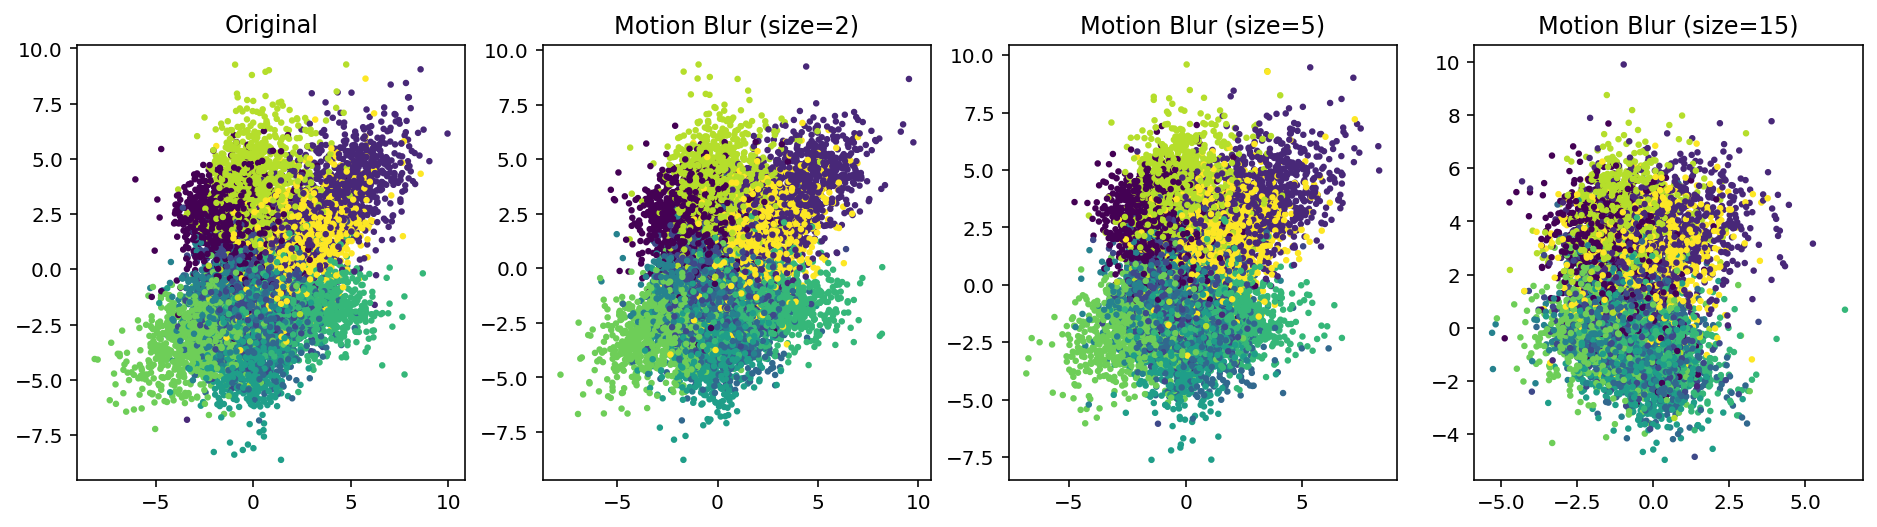

In [33]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].scatter(embeddings_original[:, 0], embeddings_original[:, 1], c=y_test, s=5)
axs[0].set_title('Original')
axs[1].scatter(embeddings_2[:, 0], embeddings_2[:, 1], c=y_test, s=5)
axs[1].set_title('Motion Blur (size=2)')
axs[2].scatter(embeddings_5[:, 0], embeddings_5[:, 1], c=y_test, s=5)
axs[2].set_title('Motion Blur (size=5)')
axs[3].scatter(embeddings_15[:, 0], embeddings_15[:, 1], c=y_test, s=5)
axs[3].set_title('Motion Blur (size=15)')

Visual inspection confirms changes to image embeddings as we add increasing quantities of motion blur.

## 4. Quantifying Concept Drift using Kolmogorov-Smirnov Test

In [34]:
from scipy.stats import ks_2samp

To quantify Concept Drift, we will apply feature-wise two-sample [Kolmogorov-Smirnov (K-S)](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) test. K-S test is a nonparametric test of equality of two continuous probability distributions.

In [57]:
p_2 = [None, None]
p_5 = [None, None]
p_15 = [None, None]

for i in range(2):
    ks, p_2[i] = ks_2samp(embeddings_original[:, i], embeddings_2[:, i],
                         alternative='two-sided', mode='asymp')
    ks, p_5[i] = ks_2samp(embeddings_original[:, i], embeddings_5[:, i],
                         alternative='two-sided', mode='asymp')
    ks, p_15[i] = ks_2samp(embeddings_original[:, i], embeddings_15[:, i],
                         alternative='two-sided', mode='asymp')

In [60]:
print('Blur (size=2) K-S p=' + str(p_2))
print('Blur (size=5) K-S p=' + str(p_5))
print('Blur (size=15) K-S p=' + str(p_15))

Blur (size=2) K-S p=[0.022342731717099936, 0.009193551941572075]
Blur (size=5) K-S p=[7.605375115625433e-33, 1.3579443056427206e-52]
Blur (size=15) K-S p=[0.0, 0.0]


As expected, Concept Drift was detected on images with motion blur, with K-S test p-values reflecting degree of corruption.